#### !pip install gdown 
!gdown https://drive.google.com/file/d/1ZrEg-9708-n1A74kj1GM8-RTUSmcGkxk/view?usp=sharing --fuzzy  
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
import pickle
data_subsets = pickle.load( open( "divided_data.p", "rb" ) )

**Training XGBoost with hypertuned parameters**

In [ ]:
!pip uninstall xgboost -y
!pip install xgboost==1.5.0

In [4]:

xgb.__version__

'1.5.0'

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [5]:
best_params = [('colsample_bytree', 0.6610854113669242),
             ('learning_rate', 0.014712214088074407),
             ('max_depth', 4),
             ('n_estimators', 5000),
             ('reg_alpha', 9.955617394667579),
             ('reg_lambda', 50.88790782562254),
             ('subsample', 0.37186871316834935)]

In [6]:
encoding_dict = {'RISK': {'high': 0, 'low': 1, 'medium': 2},
 'COUNTRY_RISK_INCOME': {'High': 0, 'Low': 1, 'Moderate': 2},
 'OCPTN_NM': {'High': 0, 'Low': 1, 'Moderate': 2},
 'COUNTRY_RISK_RESIDENCY': {'High': 0, 'Low': 1, 'Moderate': 2}}

In [7]:
def get_data_by_percentage(data_subsets, percentage):
    key = f"{percentage}%"
    if key in data_subsets:
        data = data_subsets[key]
        X_train = data['X_train']
        y_train = data['y_train']
        X_test = data['X_test']
        y_test = data['y_test']
        X_val = data['X_val']
        y_val = data['y_val']
        return X_train, y_train, X_test, y_test, X_val, y_val
    else:
        raise ValueError(f"Percentage {percentage}% not found in data subsets.")

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_auc_score, f1_score, accuracy_score, roc_curve, auc

In [107]:
percentage = 100 # Example Usage for 5%
X_train, y_train, X_test, y_test, X_val, y_val = get_data_by_percentage(data_subsets, percentage)

In [109]:

# normalize the data using MinMaxScaler
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train = le.fit_transform(y_train)
Y_test = le.fit_transform(y_test)
Y_val = le.fit_transform(y_val)

In [39]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_auc_score, f1_score, accuracy_score

# Create the DMatrix objects for XGBoost
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)
dtrain = xgb.DMatrix(X_train, label=Y_train)
dval = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test, label=Y_test)
dX = xgb.DMatrix(X, label=y)


In [12]:
params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 3,
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 1
}

In [13]:
params['objective']

'multi:softmax'

In [14]:
params.update(dict(best_params))

In [15]:
params['booster'] = 'gbtree'
params['verbosity'] = 0
params['tree_method']='gpu_hist'

In [16]:
params

{'objective': 'multi:softmax',
 'eval_metric': 'mlogloss',
 'num_class': 3,
 'eta': 0.1,
 'max_depth': 4,
 'subsample': 0.37186871316834935,
 'colsample_bytree': 0.6610854113669242,
 'verbosity': 0,
 'learning_rate': 0.014712214088074407,
 'n_estimators': 5000,
 'reg_alpha': 9.955617394667579,
 'reg_lambda': 50.88790782562254,
 'booster': 'gbtree',
 'tree_method': 'gpu_hist'}

In [ ]:
def custom_callback(env):
    epoch = env.iteration + 1
    if epoch % 10 == 0:
        y_pred_val = env.model.predict(dval)
        y_prob_val = env.model.predict(dval, output_margin=True)
        fpr_val, tpr_val, _ = roc_curve(y_val, y_prob_val[:, 1], pos_label=1)
        auc_val = auc(fpr_val, tpr_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        acc_val = accuracy_score(y_val, y_pred_val)
        f1_val = f1_score(y_val, y_pred_val, average='weighted')
        print(f"Epoch {epoch}: AUC-ROC = {auc_val:.4f}, MSE = {mse_val:.4f}, Accuracy = {acc_val:.4f}, F1-score = {f1_val:.4f}")
# Train the XGBoost model with the custom callback function
xgb_model = xgb.train(params, dtrain, evals=[(dval, 'Validation')], num_boost_round=5000, early_stopping_rounds=10, callbacks=[xgb.callback.print_evaluation(), custom_callback])

y_pred = xgb_model.predict(dtest)
y_prob = xgb_model.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred)
acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='weighted')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"MSE on test data = {mse_test:.4f}")
print(f"Accuracy on test data = {acc_test:.4f}")
print(f"F1-score on test data = {f1_test:.4f}")

0	Validation-mlogloss:1.07983
Will train until Validation-mlogloss hasn't improved in 10 rounds.
0	Validation-mlogloss:1.07983
1	Validation-mlogloss:1.06203
1	Validation-mlogloss:1.06203
2	Validation-mlogloss:1.04425
2	Validation-mlogloss:1.04425
3	Validation-mlogloss:1.02645
3	Validation-mlogloss:1.02645
4	Validation-mlogloss:1.00917
4	Validation-mlogloss:1.00917
5	Validation-mlogloss:0.99219
5	Validation-mlogloss:0.99219
6	Validation-mlogloss:0.97571
6	Validation-mlogloss:0.97571
7	Validation-mlogloss:0.95949
7	Validation-mlogloss:0.95949
8	Validation-mlogloss:0.94446
8	Validation-mlogloss:0.94446
9	Validation-mlogloss:0.92911


/opt/conda/lib/python3.7/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Epoch 10: AUC-ROC = 0.9982, MSE = 0.1924, Accuracy = 0.9472, F1-score = 0.9257
9	Validation-mlogloss:0.92911
10	Validation-mlogloss:0.91406
10	Validation-mlogloss:0.91406
11	Validation-mlogloss:0.89983
11	Validation-mlogloss:0.89983
12	Validation-mlogloss:0.88702
12	Validation-mlogloss:0.88702
13	Validation-mlogloss:0.87302
13	Validation-mlogloss:0.87302
14	Validation-mlogloss:0.85944
14	Validation-mlogloss:0.85944
15	Validation-mlogloss:0.84608
15	Validation-mlogloss:0.84608
16	Validation-mlogloss:0.83335
16	Validation-mlogloss:0.83335
17	Validation-mlogloss:0.82193
17	Validation-mlogloss:0.82193
18	Validation-mlogloss:0.81026
18	Validation-mlogloss:0.81026
19	Validation-mlogloss:0.79843
Epoch 20: AUC-ROC = 0.9987, MSE = 0.1915, Accuracy = 0.9484, F1-score = 0.9280
19	Validation-mlogloss:0.79843
20	Validation-mlogloss:0.78639
20	Validation-mlogloss:0.78639
21	Validation-mlogloss:0.77461
21	Validation-mlogloss:0.77461
22	Validation-mlogloss:0.76323
22	Validation-mlogloss:0.76323
23	Val

In [19]:
y_pred = xgb_model.predict(dtest)
y_prob = xgb_model.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred)
acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='weighted')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"MSE on test data = {mse_test:.4f}")
print(f"Accuracy on test data = {acc_test:.4f}")
print(f"F1-score on test data = {f1_test:.4f}")

              precision    recall  f1-score   support

           0       0.74      0.59      0.66     10013
           1       1.00      1.00      1.00    118467
           2       0.94      0.97      0.96     69284

    accuracy                           0.97    197764
   macro avg       0.89      0.85      0.87    197764
weighted avg       0.97      0.97      0.97    197764

[[  5907     60   4046]
 [     3 118463      1]
 [  2058     54  67172]]
MSE on test data = 0.1241
Accuracy on test data = 0.9685
F1-score on test data = 0.9670


#### 

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))

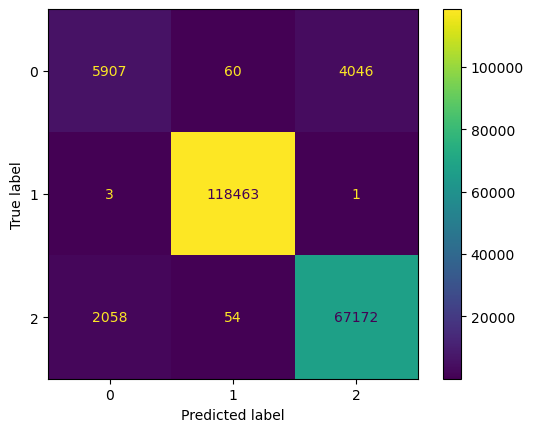

In [23]:
disp.plot()

In [26]:
xgb_model.save_model("model_final_xgb_bayes-tuned.json")

In [27]:
from IPython.display import FileLink
FileLink(r'model_final_xgb_bayes-tuned.json')

/kaggle/working/model_final_xgb_bayes-tuned.json

**Getting List of Bad Actors**

In [28]:
!wget https://kkb-production.jupyter-proxy.kaggle.net/k/120525063/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..6F_r-EqVBRR5wb-F5DN7fw.ePvzqGc-ETKlkjbahet0jq29tfd_Nz715BUzMgCGg7ooe7TXxAfoWS-AnV8gFlYKWgfp9DWRlass_OKOClyTwdRI_OgcK71gdw9YhrywVPaVkQOXnIcTNIG_bl4qgUZdARaxtmhf4E6Q6nX5lK9glZDwHBDhvLoaFLHe0G9so-GsfH9bWeXTOBkMduwhsKIWspmYil3-bDywWqOkn031bw.bpGKVFavPXTC4qGGUVlmQw/proxy/files/all_info_df.csv

--2023-02-27 18:21:47--  https://kkb-production.jupyter-proxy.kaggle.net/k/120525063/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..6F_r-EqVBRR5wb-F5DN7fw.ePvzqGc-ETKlkjbahet0jq29tfd_Nz715BUzMgCGg7ooe7TXxAfoWS-AnV8gFlYKWgfp9DWRlass_OKOClyTwdRI_OgcK71gdw9YhrywVPaVkQOXnIcTNIG_bl4qgUZdARaxtmhf4E6Q6nX5lK9glZDwHBDhvLoaFLHe0G9so-GsfH9bWeXTOBkMduwhsKIWspmYil3-bDywWqOkn031bw.bpGKVFavPXTC4qGGUVlmQw/proxy/files/all_info_df.csv
Resolving kkb-production.jupyter-proxy.kaggle.net (kkb-production.jupyter-proxy.kaggle.net)... 35.244.180.134
Connecting to kkb-production.jupyter-proxy.kaggle.net (kkb-production.jupyter-proxy.kaggle.net)|35.244.180.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208029053 (198M) [text/csv]
Saving to: ‘all_info_df.csv’

all_info_df.csv     100%[===================>] 198.39M  14.5MB/s    in 16s     

2023-02-27 18:22:04 (12.3 MB/s) - ‘all_info_df.csv’ saved [208029053/208029053]



In [80]:
original_df = pd.read_csv('all_info_df.csv')

In [81]:
original_df

,Unnamed: 0,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,...,RISK,NAME,GENDER,CUSTOMER_ID,EMAIL_CNT_OUT,EMAIL_SUM_OUT,EMAIL_CNT_IN,EMAIL_SUM_IN,REL_AGE,REL_ADD_DT
0,0,1981-09-01,2007-07-05,High,1,1,0.0,2577.785,2.0,2851.663,...,low,"Young, Marie Mildren Coleman",Female,935382.0,0.0,0.000000,0.0,0.000000,38.101370,15.068493
1,1,1994-02-21,2019-05-19,High,1,1,0.0,3035.502,2.0,4805.997,...,low,Mark Stupar Lecy,Male,2305.0,0.0,0.000000,0.0,0.000000,25.619178,3.189041
2,2,1962-11-16,2011-08-02,High,1,1,0.0,1617.571,1.0,3482.809,...,low,Dean Glasper Wendel Reeves,Male,472403.0,0.0,0.000000,0.0,0.000000,56.906849,10.989041
3,3,1998-06-20,2001-08-15,High,1,1,0.0,3587.042,5.0,1940.943,...,low,"Hulsey, Linda Rauth",Female,227994.0,0.0,0.000000,0.0,0.000000,21.290411,20.958904
4,4,1942-01-24,2012-10-28,High,1,1,0.0,1725.524,2.0,13197.169,...,low,Carolyn Washington Roberts,Female,418265.0,0.0,0.000000,0.0,0.000000,77.731507,9.747945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988815,999995,1939-01-16,1994-03-19,Low,0,1,0.0,18945.108,10.0,32210.000,...,high,Bret* Dove Gainey,Male,420884.0,4.0,3418.392838,1.0,5002.493403,80.756164,28.372603
988816,999996,1970-12-13,1995-12-22,Low,0,1,0.0,5775.601,7.0,5015.741,...,low,Anthony Ray Montano Gomez,Male,429418.0,0.0,0.000000,1.0,2955.912041,48.827397,26.610959
988817,999997,1958-09-09,2010-11-03,High,0,1,0.0,2351.255,2.0,15997.000,...,high,Bernadette Schofield Pace Mile,Female,731360.0,2.0,9927.441977,2.0,4287.453681,61.095890,11.734247
988818,999998,1983-09-15,2013-01-30,High,0,1,0.0,27312.613,8.0,3399.000,...,high,"Wasson, Russell Terrell",Male,837988.0,2.0,588.008938,5.0,9419.317616,36.063014,9.490411


In [32]:
encoding_dict = {'RISK': {'high': 0, 'low': 1, 'medium': 2},
 'COUNTRY_RISK_INCOME': {'High': 0, 'Low': 1, 'Moderate': 2},
 'OCPTN_NM': {'High': 0, 'Low': 1, 'Moderate': 2},
 'COUNTRY_RISK_RESIDENCY': {'High': 0, 'Low': 1, 'Moderate': 2}}

In [50]:
percentage = 100 # Example Usage for 5%
X_train, y_train, X_test, y_test, X_val, y_val = get_data_by_percentage(data_subsets, percentage)

In [43]:
model = xgb.Booster()
model.load_model('model_final_xgb_bayes-tuned.json')
model.set_param({'predictor': 'gpu_predictor'})

In [56]:
index_train_df = pd.DataFrame({'index': X_train.index})
index_val_df = pd.DataFrame({'index': X_val.index})
index_test_df = pd.DataFrame({'index': X_test.index})
X = pd.concat([index_train_df, index_val_df, index_test_df], axis=0)

In [61]:
y_pred = model.predict(dX)

In [62]:
results_df = pd.DataFrame({'index': range(len(X)), 'predicted_target': y_pred})

In [63]:
results_df

,index,predicted_target
0,0,2.0
1,1,2.0
2,2,1.0
3,3,2.0
4,4,2.0
...,...,...
988815,988815,1.0
988816,988816,2.0
988817,988817,2.0
988818,988818,2.0


In [99]:
X_with_predictions = X.merge(results_df[['predicted_target']], how='left', left_index=True, right_index=True)


In [100]:
merged_df = pd.merge(original_df, X_with_predictions[['index', 'predicted_target']], left_index=True, right_on='index')

# Add "CUSTOMER_ID" and "NAME" columns to merged_df
merged_df[['CUSTOMER_ID', 'NAME']] = original_df[['CUSTOMER_ID', 'NAME']]

# Drop the "index" column from merged_df
merged_df = merged_df.drop('index', axis=1)

In [101]:
merged_df

,Unnamed: 0,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,...,NAME,GENDER,CUSTOMER_ID,EMAIL_CNT_OUT,EMAIL_SUM_OUT,EMAIL_CNT_IN,EMAIL_SUM_IN,REL_AGE,REL_ADD_DT,predicted_target
318864,0,1981-09-01,2007-07-05,High,1,1,0.0,2577.785,2.0,2851.663,...,David Ramirez Downs,Female,95668.0,0.0,0.000000,0.0,0.000000,38.101370,15.068493,1.0
111859,1,1994-02-21,2019-05-19,High,1,1,0.0,3035.502,2.0,4805.997,...,David Harrell Mckeever Kim,Male,359506.0,0.0,0.000000,0.0,0.000000,25.619178,3.189041,1.0
24715,2,1962-11-16,2011-08-02,High,1,1,0.0,1617.571,1.0,3482.809,...,"Musto, Jessie",Male,598260.0,0.0,0.000000,0.0,0.000000,56.906849,10.989041,1.0
297781,3,1998-06-20,2001-08-15,High,1,1,0.0,3587.042,5.0,1940.943,...,Megan Matthews Sullivan Geiger,Female,684216.0,0.0,0.000000,0.0,0.000000,21.290411,20.958904,1.0
579195,4,1942-01-24,2012-10-28,High,1,1,0.0,1725.524,2.0,13197.169,...,Debra Wilcox Dartt,Female,634611.0,0.0,0.000000,0.0,0.000000,77.731507,9.747945,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219119,999995,1939-01-16,1994-03-19,Low,0,1,0.0,18945.108,10.0,32210.000,...,Bobby Clifton orBwn,Male,122699.0,4.0,3418.392838,1.0,5002.493403,80.756164,28.372603,2.0
164507,999996,1970-12-13,1995-12-22,Low,0,1,0.0,5775.601,7.0,5015.741,...,Fallon Perkins Ison Cleveland,Male,101972.0,0.0,0.000000,1.0,2955.912041,48.827397,26.610959,2.0
146734,999997,1958-09-09,2010-11-03,High,0,1,0.0,2351.255,2.0,15997.000,...,"Garcia, Ted Parks Dorsey",Female,760988.0,2.0,9927.441977,2.0,4287.453681,61.095890,11.734247,2.0
148667,999998,1983-09-15,2013-01-30,High,0,1,0.0,27312.613,8.0,3399.000,...,Maria Russ Taylor,Male,226711.0,2.0,588.008938,5.0,9419.317616,36.063014,9.490411,2.0


In [103]:
filtered_df = merged_df.loc[merged_df['predicted_target'].isin([0.0, 2.0]) & (merged_df['predicted_target'] != 1)]

# Select only the CUSTOMER_ID and NAME columns
selected_df = filtered_df[['CUSTOMER_ID', 'NAME']]


In [104]:
selected_df

,CUSTOMER_ID,NAME
135429,744821.0,Geraldine Crosby Byrne Downey
141350,5251.0,Sally Fife Andrews Wigley
95097,175164.0,Meredith Fissel W/eblase Lopez
175133,748487.0,Kendrick Zerhusen Frederickson Tucker
88327,79523.0,Charlene Peoples Garland
...,...,...
219119,122699.0,Bobby Clifton orBwn
164507,101972.0,Fallon Perkins Ison Cleveland
146734,760988.0,"Garcia, Ted Parks Dorsey"
148667,226711.0,Maria Russ Taylor


In [105]:
selected_df.to_csv('TEAM-19-BAD-ACTORS.csv', index=False)